<a target="_blank" href="https://colab.research.google.com/github/avakanski/Fall-2022-Python-Programming-for-Data-Science/blob/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2021%20-%20Model%20Selection%2C%20Hyperparameter%20Tuning/Lecture%2021%20-%20Model%20Selection%2C%20Hyperparameter%20Tuning.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<a name='section0'></a>
# Lecture 21 Model Selection, Hyperparameter Tuning

- [21.1 Model Selection](#section1)
- [21.2 Evaluate the Impact of Learning Rate](#section2)
    - [21.2.1 Learning Rate Finder](#section2-1)
- [21.3 Callbacks](#section3)
    - [21.3.1 Early Stopping](#section3-1)
    - [21.3.2 Save Checkpoint](#section3-2)
    - [21.3.3 Reduce Learning Rate on Plateau](#section3-3)
    - [21.3.4 Learning Rate Scheduler](#section3-4)
- [21.4 Grid Search](#section4) 
- [21.5 Keras Tuner](#section5)    
- [21.6 AutoML](#section6) 
- [References](#section10)






<a name='section1'></a>

# 20.1 Model Selection

***Model selection*** in Machine Learning is selecting one final model for a given task, e.g., that will be deployed in production. In general, selecting the "best" model should be based not only on the obtained values of relevant performance metrics (accuracy, specificity, sensitivity), but also based on other considerations, such as computational expense, available resources, model complexity, maintainability, and similar.

An important phase in selecting a candidate Machine Learning model is ***hyperparameter tuning***. In the previous lecture on scikit-learn, we mentioned that ***parameters (weights)*** of the model have values that are updated in an iterative process during training, whereas ***hyperparameters*** (tuning parameters) are a set of parameters that control the complexity and performance of the model, and are selected (tuned) by the user. The hyperparameters are not updated during model training, and they stay constant. ***Hyperparameter tuning*** (also known as hypertuning) is the process of selecting hyperparameter values to find a model that generalizes well to unseen data. In the previous lectures, we explained that scikit-learn offers functions for Grid Search and Random Search, which search for solutions over different values of the hyperparameters and select an optimal set of hyperparameters for a given performance metric. 

Another important aspect for model selection is the evaluation of model performance. It is particularly important to evaluate candidate models on unseen data during training, and this is typically achieved by splitting the available data into training and test datasets. We also learned that *k*-fold cross-validation can be used to draw folds from the available data, and evaluate the models on multiple different folds by resampling the available data. With *k*-fold cross-validation, each data point can appear only in one of the folds when evaluating the model performance. 

Model selection in general can involve various data preprocessing techniques, evaluating different feature engineering strategies, applying Ensemble Methods to aggregate the predictions from several individual Machine Learning models, etc. 

In this lecture, we will focus on hyperparameter tuning with neural networks. Namely, neural networks are more sensitive to hyperparameter tuning than conventional Machine Learning models (such as Liner Regression, k-Nearest Neighbors, etc.). We saw in the previous lectures that even if we use default values for the models in scikit-learn without any hyperparameter tuning, the models can still achieve solid performance. This is rarely the case with neural networks, as they usually require at least some hyperparameter tuning. 

One note is to not confuse *hyperparameter tuning* with *model fine-tuning*, which refers to using a pretrained model on a large dataset, and fine-tuning the model parameters on a smaller dataset. 

### Hyperparameters in Neural Networks

Let's examine again the ConvNet that we used in a previous lecture to classify images in the CIFAR-10 dataset, and let's try to identify the hyperparameters of the model.

```
# define the layers in the model
inputs = Input(shape=(32, 32, 3))
conv1a = Conv2D(filters=32, kernel_size=3, padding='same')(inputs)
conv1b = Conv2D(filters=32, kernel_size=3, padding='same')(conv1a)
pool1 = MaxPooling2D()(conv1b)
conv2a = Conv2D(filters=64, kernel_size=3, padding='same')(pool1)
conv2b = Conv2D(filters=64, kernel_size=3, padding='same')(conv2a)
pool2 = MaxPooling2D()(conv2b)
conv3a = Conv2D(filters=128, kernel_size=3, padding='same')(pool2)
conv3b = Conv2D(filters=128, kernel_size=3, padding='same')(conv3a)
pool3 = MaxPooling2D()(conv3b)
flat = Flatten()(pool3)
dense1 = Dense(128, activation='relu')(flat)
dropout1 = Dropout(0.25)(dense1)
dense2 = Dense(64, activation='relu')(dropout1)
dropout2  = Dropout(0.25)(dense2)
outputs = Dense(10, activation='softmax')(dropout2)

# define the model with inputs and outputs
cifar_cnn = Model(inputs, outputs)

# compile the model
cifar_cnn.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy',  metrics=['accuracy'])

# train the model
cifar_cnn.fit(train_data, train_label_onehot, epochs=10, batch_size=128)
```

Hyperparameters in the above model include:
- Learning rate of the optimizer
- Batch size
- Number of training epochs
- Number of Convolutional layers
- Number of convolutional filters in the Convolutional layers
- Kernel size of the convolutional filters
- Type of padding in the Convolutional layers
- Number of Dense layers
- Number of neurons in each Dense layer
- Type of activation functions used in the layers
- Number of Dropout layers
- Dropout rate in the Dropout layers
- Type of optimizer (e.g., Adam, SGD, Nadam, RMSProp)
- Other parameters used in the optimizer (e.g., momentum)
- Type of initialization for the parameters in the model

There can be other hyperparameters depending on the network, however, one immediate observation is that neural networks have a large number of hyperparameters, and tuning all hyperparameters can be challenging. And that is true, it may take significant time and resources to tune the hyperparameters in neural networks.

On the other hand, not all of the hyperparameters have significant impact on  the performance of the model. Out of all hyperparameters, probably the most important is the learning rate, and in most cases, some tuning of the learning rate is required. In this lecture we will present techniques for hyperparameter tuning of a ConvNet model built with Keras and TensorFlow.

<a name='section2'></a>

# 21.2 Evaluate the Impact of the Learning Rate

### Loading the Dataset

For this lecture, we will use the LFW dataset (Labeled Faces in the Wild), which consists of about 5,000 images of 62 celebrities. Let's load the dataset and plot a few images to make sure that the labels are correct.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img,  img_to_array
import os
from os import listdir
import csv
import natsort 

# Print the version of tf
print("TensorFlow version:{}".format(tf.__version__))
print("Keras version:{}".format(keras.__version__))

TensorFlow version:2.9.2
Keras version:2.9.0


In [3]:
# Path to the directory containing the dataset
!unzip -uq 'drive/MyDrive/Data_Science_Course/Lecture_21-Model_Selection,Tuning/data/LFW-dataset.zip' -d 'sample_data/'

Images train shape: (3043, 100, 100, 3) - Labels train shape: (3043,)
Images validation shape: (1021, 100, 100, 3) - Labels validation shape: (1021,)
Images test shape: (1049, 100, 100, 3) - Labels test shape: (1049,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.4739037699151936
Data type float64


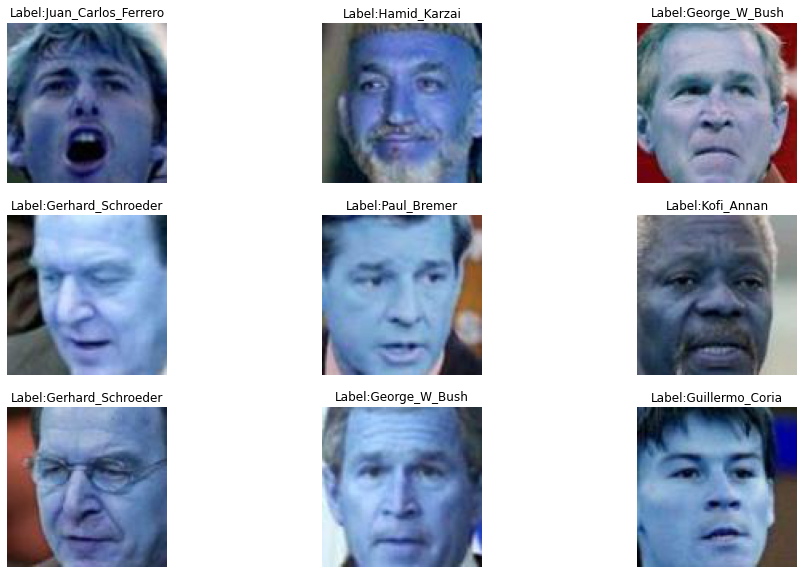

In [4]:
# Function for loading the images
def load_imgs(path):
    # List of all images in the folder
    imgList = listdir(path)
    # Make sure that the images are sorted in ascending order
    imgList=natsort.natsorted(imgList)
    # Number of images
    number_imgs = len(imgList)
    # Initialize numpy arrays for the images
    images = np.zeros((number_imgs, image_size, image_size, 3))
    # Read the images
    for i in range(number_imgs):
        tmp_img = load_img(path + imgList[i], target_size=(image_size, image_size, 3))
        img = img_to_array(tmp_img)
        images[i] = img/255.0
    return images

# Directories
train_dir = 'sample_data/LFW-dataset/Train/'
test_dir = 'sample_data/LFW-dataset/Test/'
val_dir = 'sample_data/LFW-dataset/Validation/'
labels_dir = 'sample_data/LFW-dataset/'

# Size of images (pixel width and height)
image_size = 100

# Call the above function to load the images as numpy arrays
imgs_train = load_imgs(train_dir)
imgs_test = load_imgs(test_dir)
imgs_val = load_imgs(val_dir)

# Load the labels as numpy arrays
labels_train = np.genfromtxt(labels_dir + "train_labels.csv", delimiter=',', dtype=np.int32)
labels_test = np.genfromtxt(labels_dir + "test_labels.csv", delimiter=',', dtype=np.int32)
labels_val = np.genfromtxt(labels_dir + "val_labels.csv", delimiter=',', dtype=np.int32)

# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(imgs_train.shape, labels_train.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(imgs_val.shape, labels_val.shape))
print('Images test shape: {} - Labels test shape: {}'.format(imgs_test.shape, labels_test.shape))

# Display the range of images (to make sure they are in the [0, 1] range)
print('\nMax pixel value', np.max(imgs_train))
print('Min pixel value', np.min(imgs_train))
print('Average pixel value', np.mean(imgs_train))
print('Data type', imgs_train[0].dtype)

# Read the names of the celebrities in the dataset (there are 62 celebrities)
name_list = []
with open(labels_dir+'name_list.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        name_list.append(row[1])

# Plot a few images to check if the the labels are correct
# There are a few bad images in the dataset, it needs to be cleaned
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(0, len(imgs_train), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(imgs_train[i[0]])
    plt.title('Label:' + str(name_list[labels_train[i[0]]]))
    plt.axis('off')

### Define the Model

We will use a pretrained VGG-16 model, and we will just add a classifier with 3 Dense layers on top of the model to fine-tune it to the LFW dataset.

In [11]:
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import vgg16

import datetime
now = datetime.datetime.now

In [6]:
def Network():

    base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    # Add a softmax layer
    predictions = Dense(62, activation='softmax')(x)

    # The model 
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

Let's define a function for plotting the accuracy and loss called `plot_accuracy_loss`, which we can call with different models to examine the learning curves. 

In [7]:
def plot_accuracy_loss():
    # plot the accuracy and loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy'] 
    val_acc = history.history['val_accuracy']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1,2,1)
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()            
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1,2,2)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show() 

### Learning rate = 1e-4, Epochs = 10

The following code trains a model for 10 epochs with a learning rate of `1e-4 = 0.0001`. We have selected this learning rate because we know that it works well for this combination of model and data.

We can see that the model achieved 90.18% accuracy on the test set, and the training took about 2 minutes. From the plots of the accuracy and loss curves, we can tell that 10 epochs are not sufficient for training the model, because at the end of the 10th epoch, the accuracy was still increasing and the loss was decreasing. 

58889256/58889256 [==============================] - 0s 0us/step

Training time: 0:02:01.483512
33/33 [==============================] - 2s 57ms/step - loss: 0.4006 - accuracy: 0.9018
Classification Accuracy:  90.18112421035767


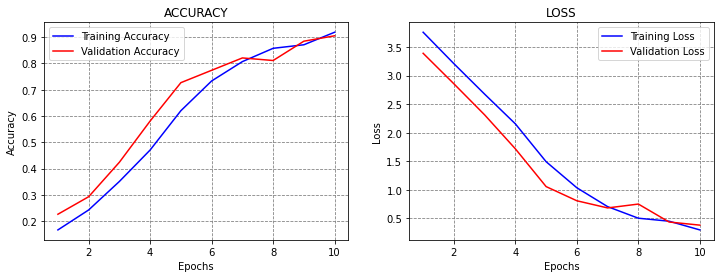

In [ ]:
LEARNING_RATE = 1e-4
EPOCHS_NUM = 10

model = Network()
model.compile(optimizer = Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM, 
                     validation_data=(imgs_val, labels_val), verbose=0)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### Learning rate = 1e-4, Epochs = 30

Let's train the model for 30 epochs using the same learning rate to see if this number of epochs would be sufficient. 

From the results we can see that the model achieved 91.61% accuracy, and the training took about 6 minutes. 

Based on the learning curves, at epoch 30 the validation accuracy and loss were converging to a plateau level, and it was unclear if training the model for more than 30 epochs would improve the performance. An alternative is to use Early Stopping callback, so that the training is stopped automatically (e.g., when the validation loss stops decreasing). Such case is shown in a subsequent section.


Training time: 0:05:39.578695
33/33 [==============================] - 1s 38ms/step - loss: 0.3680 - accuracy: 0.9161
Classification Accuracy:  91.61105751991272


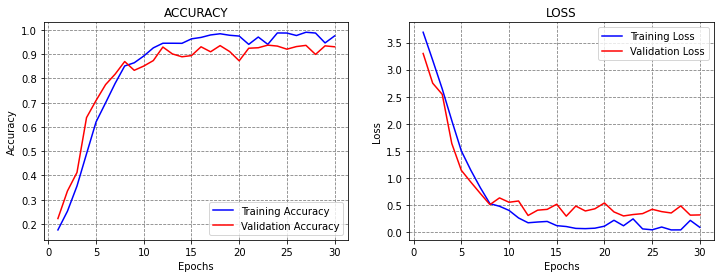

In [ ]:
LEARNING_RATE = 1e-4
EPOCHS_NUM = 30

model = Network()
model.compile(optimizer = Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM, 
                     validation_data=(imgs_val, labels_val), verbose=0)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### Learning rate = 1e-3, Epochs = 20

Next, let's try to train the model using different learning rates, for instance, by increasing the learning rate to `1e-3 = 0.001`.

Increasing the learning rate will cause the model to apply larger values for the update of the parameters during the training. We can expect that the training will converge faster, and we can use a smaller number of epochs. 

However, large learning rates can cause the model to update the parameters too fast, as in this case. As we can see, the model achieved only 16.87% accuracy, and the accuracy curves did not improve after that level.


Training time: 0:03:35.263105
33/33 [==============================] - 1s 37ms/step - loss: 3.7223 - accuracy: 0.1687
Classification Accuracy:  16.873212158679962


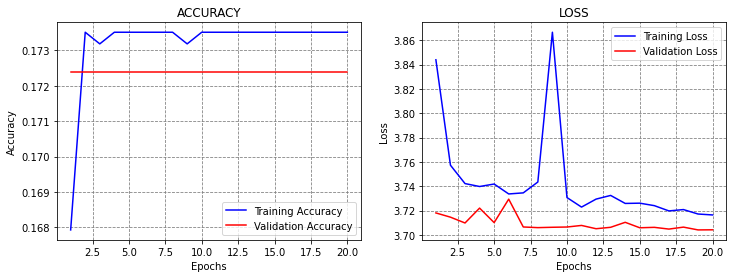

In [ ]:
LEARNING_RATE = 1e-3
EPOCHS_NUM = 20

model = Network()
model.compile(optimizer = Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM, 
                     validation_data=(imgs_val, labels_val), verbose=0)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### Learning rate = 1e-2, Epochs = 10

If we increase the learning rate even further to `0.01`, we can expect that training will fail, since we saw that even a learning rate of `0.001` was too high. Based on the learning curves, we can tell that the learning is too fast and too aggressive.


Training time: 0:01:46.387700
33/33 [==============================] - 1s 36ms/step - loss: 3.7226 - accuracy: 0.1687
Classification Accuracy:  16.873212158679962


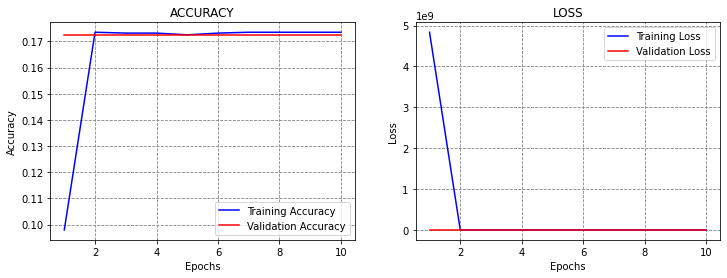

In [ ]:
LEARNING_RATE = 1e-2
EPOCHS_NUM = 10

model = Network()
model.compile(optimizer = Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM, 
                     validation_data=(imgs_val, labels_val), verbose=0)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### Learning rate = 1e-5, Epochs = 50

Let's try the opposite case, and reduce the learning rate to `1e-5 = 0.00001`. Smaller learning rates produce smaller updates of the model parameters, and slower learning. This may avoid the problems of learning too fast when large learning rates are used.

This model achieved 94.37% accuracy, which is higher than the accuracy with the `1e-4` learning rate. Also, the learning curves look good, because the accuracy and loss gradually change, and the validation curves follow the training curves. 




Training time: 0:09:27.684121
33/33 [==============================] - 1s 38ms/step - loss: 0.2719 - accuracy: 0.9438
Classification Accuracy:  94.37559843063354


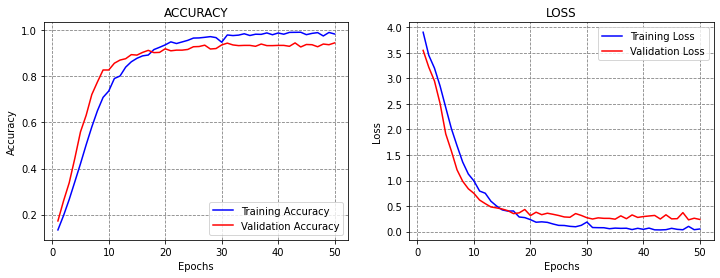

In [ ]:
LEARNING_RATE = 1e-5
EPOCHS_NUM = 50

model = Network()
model.compile(optimizer = Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM, 
                     validation_data=(imgs_val, labels_val), verbose=0)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### Learning rate = 1e-6, Epochs = 50

Next, let's reduce the learning rate even further to `1e-6`. 

Although smaller learning rates avoid training failure when we used overly large learning rates, using very small learning rates does not necessarily lead to improved performance, since the learning can be too slow. 

Based on the learning curves, we can tell that at the end of epoch 50 the model parameters were gradually being updated, and that with this learning rate we would need to train the model for at least 2-300 epochs to reach convergence. 


Training time: 0:09:25.480266
33/33 [==============================] - 1s 38ms/step - loss: 1.4210 - accuracy: 0.6883
Classification Accuracy:  68.82745623588562


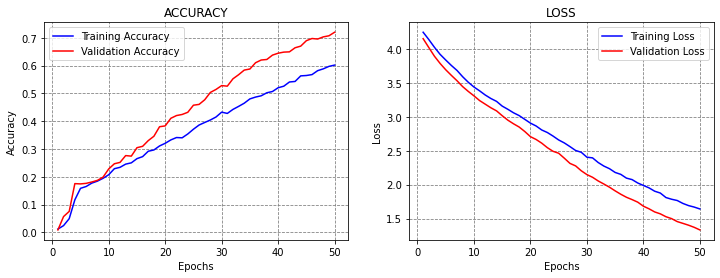

In [ ]:
LEARNING_RATE = 1e-6
EPOCHS_NUM = 50

model = Network()
model.compile(optimizer = Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM, 
                     validation_data=(imgs_val, labels_val), verbose=0)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

<a name='section2-1'></a>

## 21.2.1 Learning Rate Finder

There are several tools for estimating the learning rate, such as `LRFinder` in Keras. This function changes the learning rate in a range of values, typically starting with very small learning rate and increasing it to a high learning rate. The model is trained and evaluated for a few epochs using different learning rates. Based on a plot of the loss for different learning rates, this function can help to find a suitable learning rate, that can afterward be used to fully train the model. 

For the task at hand, the plot of loss versus learning rate is shown below. The best learning rate is the one when the loss is reducing the fastest, and has the largest slope. From the graph, this value is about $10^{-4}$. 

Although such tools can identify a range of suitable values for the learning rate, they should be taken with caution, and the users should still run candidate models in the suggested range to fully evaluate the model performance.

In [ ]:
!git clone https://github.com/WittmannF/LRFinder.git

Cloning into 'LRFinder'...
remote: Enumerating objects: 71, done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 71
Unpacking objects: 100% (71/71), done.


In [ ]:
from LRFinder.keras_callback import LRFinder

Epoch 1/2
 6/96 [>.............................] - ETA: 11s - loss: 4.1732 - accuracy: 0.0000e+00

96/96 [==============================] - 36s 122ms/step - loss: 4.1457 - accuracy: 0.0214
Epoch 2/2
96/96 [==============================] - 12s 120ms/step - loss: 3660.4465 - accuracy: 0.0796


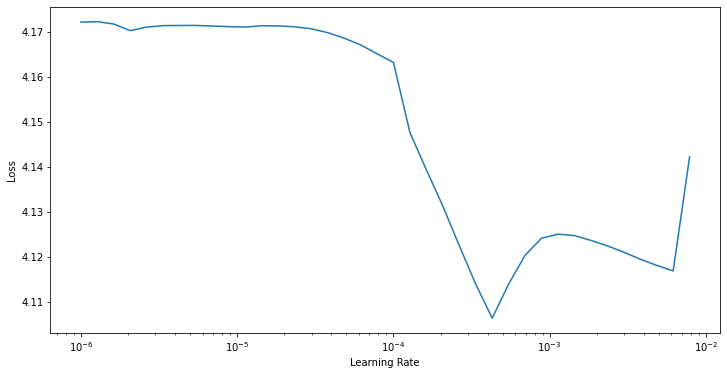

In [ ]:
model = Network()
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Perform the Learning Rate Range Test
lr_finder = LRFinder(min_lr=1e-6, max_lr=1e-2)

model.fit(imgs_train, labels_train, batch_size=32, callbacks=[lr_finder], epochs=2)

<a name='section3'></a>

# 21.3 Callbacks

In the lecture  on ConvNets we mentioned that callbacks can be used to monitor the model performance and take certain actions. The next section provides additional examples of applying callbacks to the ConvNet model in Keras.

<a name='section3-1'></a>

## 21.3.1 Early Stopping Callback

As we know, using Early Stopping callback is often beneficial, since we don't need to guess the optimal number of epochs to train the model. Instead, the callback will terminate the training when a selected metric is not improving. In the next cell, we specified to stop the training when the validation loss does not improve for 20 epochs (`patience` argument). We set the `EPOCH_NUM` argument to 1000, although we know that the model will terminate after about 50-60 epochs. Therefore, the number of epochs is not very important when we use this callback, it only needs to be large enough so that the training is not stopped prematurely.

This model achieved 91.13% accuracy. However, from the accuracy curve it seems that the accuracy was higher in the previous epoch, and it just dropped in the last epoch. We will see next how to avoid this by using CheckPoint callback.


Training time: 0:08:28.139167
33/33 [==============================] - 1s 38ms/step - loss: 0.4212 - accuracy: 0.9113
Classification Accuracy:  91.13441109657288


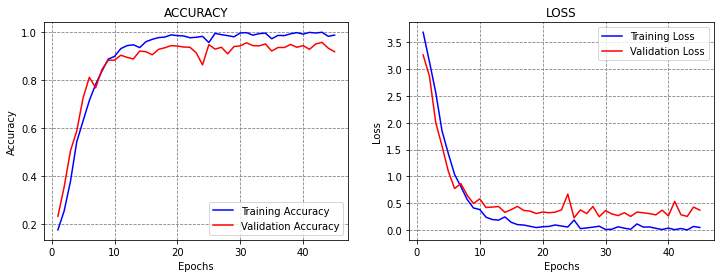

In [ ]:
LEARNING_RATE = 1e-4
EPOCHS_NUM = 1000

model = Network()
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
callbacks = [EarlyStopping(monitor='val_loss', patience=20)]
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM, 
                     validation_data=(imgs_val, labels_val), verbose=0, callbacks=callbacks)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

<a name='section3-2'></a>

## 21.3.2 CheckPoint Callback

***CheckPoint*** callback saves a checkpoint of the model (i.e., the model parameters) after every epoch when a monitored metric does not improve. We set the metrics to be the validation loss, and the values of the model parameters will be saved at the specified `filepath`. This can be useful if training the model takes hours, where if something goes wrong, we can just resume the training from a checkpoint. 

We choose to set `verbose=1` for the callback, to output the epochs at which a checkpoint is saved. 

At the beginning of the training, the checkpoint will be saved after every epoch, and after the model reaches a plateau, a new checkpoint will be saved only when there is an improvement in the performance, by overwriting the latest checkpoint.



Epoch 1: saving model to sample_data/model_celeb.h5

Epoch 2: saving model to sample_data/model_celeb.h5

Epoch 3: saving model to sample_data/model_celeb.h5

Epoch 4: saving model to sample_data/model_celeb.h5

Epoch 5: saving model to sample_data/model_celeb.h5

Epoch 6: saving model to sample_data/model_celeb.h5

Epoch 7: saving model to sample_data/model_celeb.h5

Epoch 8: saving model to sample_data/model_celeb.h5

Epoch 9: saving model to sample_data/model_celeb.h5

Epoch 10: saving model to sample_data/model_celeb.h5

Epoch 11: saving model to sample_data/model_celeb.h5

Epoch 12: saving model to sample_data/model_celeb.h5

Epoch 13: saving model to sample_data/model_celeb.h5

Epoch 14: saving model to sample_data/model_celeb.h5

Epoch 15: saving model to sample_data/model_celeb.h5

Epoch 16: saving model to sample_data/model_celeb.h5

Epoch 17: saving model to sample_data/model_celeb.h5

Epoch 18: saving model to sample_data/model_celeb.h5

Epoch 19: saving model to sample_dat

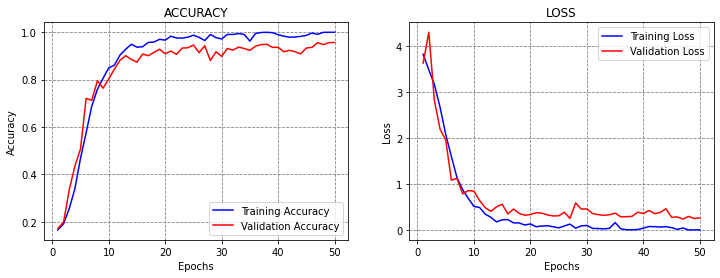

In [ ]:
LEARNING_RATE = 1e-4
EPOCHS_NUM = 50

model = Network()
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
callbacks = ModelCheckpoint(filepath='sample_data/model_celeb.h5', monitor='val_loss', mode='min', save_weights_only=True, verbose=1)
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM, 
                     validation_data=(imgs_val, labels_val), verbose=0, callbacks=[callbacks])
print('Training time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

<a name='section3-3'></a>

## 21.3.3 ReduceLROnPlateau Callback

***ReduceLROnPlateau*** stands for Reduce Learning Rate on Plateau. It is another very useful callback, since prior works have reported that training models generally benefits from using larger learning rate at the beginning of the training, and gradually reducing the learning rate when the training does not improve. 

This is exactly what this callback does. In the next call, the learning rate is initially set to `1e-4=0.0001`. ReduceLROnPlateau has a patience of 10 epochs, factor of 0.1, and minimum learning rate of `1e-6`. This means that when the monitored metric (in this case, the validation loss) does not reduce for 10 epochs, the learning rate will be multiplied by the `factor` and become `1e-5`. When the model stops improving again, the learning rate will be again multiplied by the factor and become `1e-6`. Since this is the minimum value for the learning rate, we will combine this callback with Early Stopping to terminate the training. Note that the patience value for Early Stopping was set longer than the patience for ReduceLROnPlateau.



Epoch 27: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 44: ReduceLROnPlateau reducing learning rate to 1e-06.

Training time: 0:10:10.307770
33/33 [==============================] - 1s 39ms/step - loss: 0.3501 - accuracy: 0.9466
Classification Accuracy:  94.66158151626587


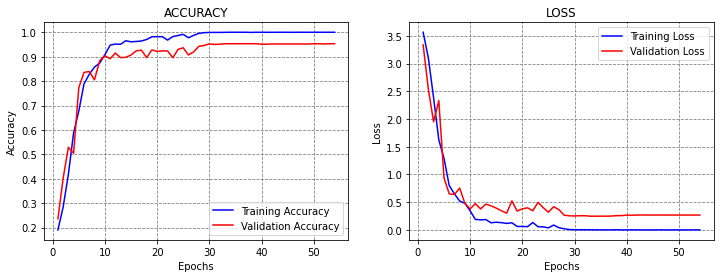

In [ ]:
LEARNING_RATE = 1e-4
EPOCHS_NUM = 1000

model = Network()
model.compile(optimizer=Adam(learning_rate = LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
callbacks = [EarlyStopping(monitor='val_loss', patience = 20),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6, verbose=1)]
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM, 
                     validation_data=(imgs_val, labels_val), verbose=0, callbacks=callbacks)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", 100*evals_test[1])


# plot the accuracy and loss
plot_accuracy_loss()

<a name='section3-4'></a>

## 21.3.4 Learning Rate Scheduler Callback

Learning Rate Scheduler allows to define custom schedulers for adjusting the learning rate during training. Popular learning rate schedules include:
- Time-based decay
- Step decay
- Exponential decay

### Time-based Decay

This scheduler decreases the learning rate in each epoch by a given fixed amount. An example is shown in the next figure, where a model is trained for 100 epochs, and the learning rate is gradually reduced from 0.01 in the first epoch to 0.006 in the last epoch.

<img src='https://raw.githubusercontent.com/avakanski/Fall-2022-Python-Programming-for-Data-Science/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2021%20-%20Model%20Selection%2C%20Hyperparameter%20Tuning/images/time_based_decay.png' width=500px/>

The implementation is shown below, where the Learning Rate Scheduler callback accepts a function which defines the schedule for the learning rate. The function `lr_time_based_decay` applies the `decay` amount at each epoch, where `lr` is the learning rate from the previous epoch. The value of the decay is usually set as the quotient of the initial learning rate and the number of epochs.


Training time: 0:09:06.291036
33/33 [==============================] - 1s 38ms/step - loss: 1.1910 - accuracy: 0.8313
Classification Accuracy:  83.12678933143616


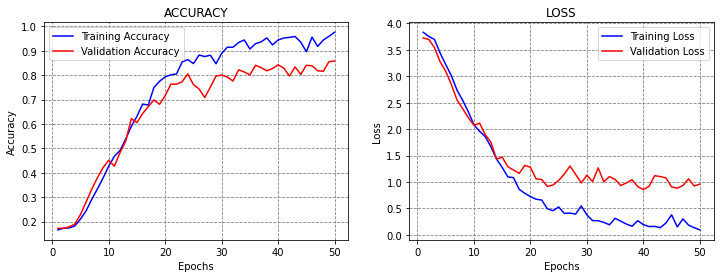

In [14]:
INITIAL_LEARNING_RATE = 1e-4
EPOCHS_NUM = 50
decay = INITIAL_LEARNING_RATE / EPOCHS_NUM

def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

model = Network()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
callbacks = [LearningRateScheduler(lr_time_based_decay, verbose=0)]
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM, 
                     validation_data=(imgs_val, labels_val), verbose=0, callbacks=callbacks)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

In this case, it seems that the learning rate was reduced too fast, because the performance decreased.

### Step Decay

Step decay scheduler decreases the learning rate for a fixed amount after a number of training epochs. An example is shown in the figure, where the learning rate is reduced by half every 10 epochs.

<img src='https://raw.githubusercontent.com/avakanski/Fall-2022-Python-Programming-for-Data-Science/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2021%20-%20Model%20Selection%2C%20Hyperparameter%20Tuning/images/step_decay.png' width=500px/>

In the next cell, step decay is applied with the function `lr_step_decay`, where `drop_rate` is the reduced ratio of the initial learning rate at each step, and `epochs_drop` is set to 15 epochs. 


Training time: 0:09:30.344202
33/33 [==============================] - 1s 39ms/step - loss: 0.3824 - accuracy: 0.9504
Classification Accuracy:  95.04289627075195


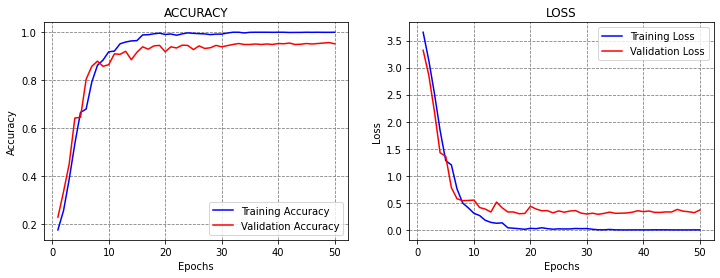

In [16]:
import math

INITIAL_LEARNING_RATE = 1e-4
EPOCHS_NUM = 50

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 15
    return INITIAL_LEARNING_RATE * math.pow(drop_rate, math.floor(epoch/epochs_drop))

model = Network()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
callbacks = [LearningRateScheduler(lr_step_decay, verbose=0)]
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM, 
                     validation_data=(imgs_val, labels_val), verbose=0, callbacks=callbacks)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### Exponential Decay

The scheduler decreases the learning rate at an exponential rate. In the cell below `k` is the rate of exponential decay.

<img src='https://raw.githubusercontent.com/avakanski/Fall-2022-Python-Programming-for-Data-Science/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2021%20-%20Model%20Selection%2C%20Hyperparameter%20Tuning/images/exponential_decay.png' width=500px/>




Training time: 0:09:31.990982
33/33 [==============================] - 1s 39ms/step - loss: 0.3819 - accuracy: 0.9485
Classification Accuracy:  94.85223889350891


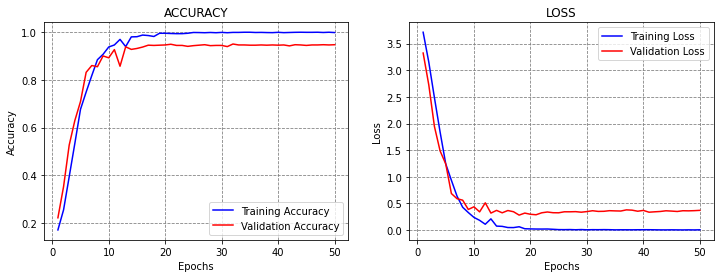

In [17]:
INITIAL_LEARNING_RATE = 1e-4
EPOCHS_NUM = 50

def lr_exp_decay(epoch, lr):
    k = 0.1
    return INITIAL_LEARNING_RATE * math.exp(-k*epoch)

model = Network()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
callbacks = [LearningRateScheduler(lr_exp_decay, verbose=0)]
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM, 
                     validation_data=(imgs_val, labels_val), verbose=0, callbacks=callbacks)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

<a name='section4'></a>

# 21.4 Grid Search

Applying Grid Search over hyperparameters of neural networks models that have long training times can be prohibitively computationally expensive. On the other hand, when working with smaller datasets and models, applying Grid Search for some of the hyperparameters can be an option. 

This section presents a simple Grid Search over two hyperparameters in the model: number of neurons in the first Dense layer, and the batch size. We can simply write a function that takes as arguments these two hyperparameters, as in the next cell. Afterward, we can create a for-loop and train and evaluate a model for each combination of the values for the selected hyperparameters. 

We examined 3 values for the number of neurons and 3 values for the batch size, resulting in 9 models. The results indicate that the model with 1,024 neurons and 128 batch size achieved the best performance. Consider that training each model took about 10 minutes, and evaluating 9 models took about 1.5 hours. Tuning a large number of hyperparameters over several different values can take long time.


In [ ]:
def Network(neurons_per_layer, batch_size):

    base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
      
    x = Dense(neurons_per_layer, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    # Add a softmax layer
    predictions = Dense(62, activation='softmax')(x)

    # The model 
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile
    model.compile(optimizer=Adam(learning_rate=1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    # Fit
    model.fit(imgs_train, labels_train, batch_size=batch_size, epochs=30, 
                     validation_data=(imgs_val, labels_val), verbose=0)
    
    # Evaluate on test data
    _, test_acc = model.evaluate(imgs_test, labels_test)

    return test_acc

In [ ]:
neurons_per_layers = [512, 1024, 2048]
batch_sizes = [32, 64, 128]

for number_neurons in neurons_per_layers:
    for batch_size in batch_sizes:
        acc = Network(number_neurons, batch_size)
        print('\nNumber of neurons', number_neurons, 
                '\tBath size', batch_size,
                '\tTest accuracy', acc)

33/33 [==============================] - 1s 38ms/step - loss: 0.3991 - accuracy: 0.9218

Number of neurons 512 	Bath size 32 	Test accuracy 0.9218302965164185
33/33 [==============================] - 1s 38ms/step - loss: 0.4094 - accuracy: 0.9171

Number of neurons 512 	Bath size 64 	Test accuracy 0.9170638918876648
33/33 [==============================] - 1s 38ms/step - loss: 0.3639 - accuracy: 0.9399

Number of neurons 512 	Bath size 128 	Test accuracy 0.9399427771568298
33/33 [==============================] - 1s 38ms/step - loss: 0.3111 - accuracy: 0.9352

Number of neurons 1024 	Bath size 32 	Test accuracy 0.9351763725280762
33/33 [==============================] - 1s 38ms/step - loss: 0.3525 - accuracy: 0.9342

Number of neurons 1024 	Bath size 64 	Test accuracy 0.9342230558395386
33/33 [==============================] - 1s 38ms/step - loss: 0.3102 - accuracy: 0.9466

Number of neurons 1024 	Bath size 128 	Test accuracy 0.9466158151626587
33/33 [==============================] - 

<a name='section5'></a>

# 21.5 Keras Tuner

There are several libraries developed for tuning the hyperparameters of neural networks. One is the ***Keras Tuner*** for tuning Keras models. 

The Keras Tuner is somewhat similar to the Grid Search and Random Search in scikit-learn, and allows to define the search space for the hyperparameters over which the model will be fit, and it returns an optimal set of hyperparameters. 

Keras Tuner is not part of the `Keras` package and it needs to be installed and imported. 

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 29.9 MB/s 
     |████████████████████████████████| 1.6 MB 56.6 MB/s 


In [ ]:
import keras_tuner as kt

### Load MNIST Dataset

To demonstrate the use of the Keras Tuner we will work with the MNIST dataset. 

In [ ]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

4422102/4422102 [==============================] - 0s 0us/step


### Model Builder

In the cell below, a function called `model_biilder` is created, which performs search over two hyperparameters:

- Number of neurons in the first Dense layer,
- Learning rate. 

The line `hp_units = hp.Int('units', min_value=32, max_value=512, step=32)` defines a grid search for the number of neurons in the Dense layer in the range [32, 64, 96, ..., 512].

Next, a grid search for the learning rate is defined in the range `[1e-2, 1e-3, 1e-4]`.

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

### Hyperparameter Tuning

The Keras Tuner has four tuning algorithms available: 

- RandomSearch Tuner, similar to the Random Grid in scikit-learn performs a random search over a distribution of values for the hyperparameters.
- Hyperband Tuner, trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round, to converge to a high-performing model. 
- BayesianOptimization Tuner, performs BayesianOptimization by creating a probabilistic mapping of the model to the loss function, and iteratively evaluating promising sets of hyperparameters.
- Sklearn Tuner, designed for use with scikit-learn models.

In the next cell, the Hyperband tuner is used, which has as the arguments the model, objective (metric) to monitor, the number of epochs, and factor (used to search for top-performing models).

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3)

In [ ]:
tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Trial 30 Complete [00h 00m 33s]
val_accuracy: 0.8552500009536743

Best val_accuracy So Far: 0.8865833282470703
Total elapsed time: 00h 09m 32s


In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Optimal number of neuron in the Dense layer: {best_hps.get('units')}")
print (f"Optimal learning rate: {best_hps.get('learning_rate')}")

Optimal number of neuron in the Dense layer: 480
Optimal learning rate: 0.001


### Train and Evaluate the Model

Next, we will use the optimal hyperparameters from the Keras Tuner to create a model, and afterward we will evaluate the accuracy on the test dataset. 


In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
model.fit(img_train, label_train, epochs=50, validation_split=0.2, verbose=0)

eval_result = model.evaluate(img_test, label_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 2ms/step - loss: 0.5827 - accuracy: 0.8874
[test loss, test accuracy]: [0.5827264189720154, 0.8873999714851379]


<a name='section6'></a>

# 21.6 AutoML

***AutoML*** or Automated Machine Learning refers to tools and libraries that are designed to allow non-ML experts to build Machine Learning systems and solve Data Science tasks without extensive knowledge in these fields. 

AutoML systems range from automated *No Code* ML solutions that allow the end-users to just drag-and-drop their data, or *Low Code* systems that automate ML steps with minimal coding efforts, to systems that require coding experience and are designed to increase the efficiency of data scientists by automating hyperparameter tuning and architecture search.

Most large providers of cloud computing and ML services typically provide some form of AutoML services. Examples include [GoogleAutoML](https://cloud.google.com/automl), [Microsoft Azure AutoML](https://azure.microsoft.com/en-us/products/machine-learning/automatedml/#overview), [Amazon SageMaker](https://aws.amazon.com/sagemaker/), etc.

Today we will have a tutorial on [AutoTrain](https://huggingface.co/autotrain) by Hugging Face, which is a No Code ML platform that allows non-experts to  train models with text, images, tabular, and other data formats. 

Other libraries that perform model selection, hyperparameter tuning, and neural architecture search include [Auto-PyTorch](https://github.com/automl/Auto-PyTorch), [AutoKeras](https://autokeras.com/), [auto-sklearn](https://github.com/automl/auto-sklearn), [Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) for PyTorch, [AutoWEKA](https://www.cs.ubc.ca/labs/algorithms/Projects/autoweka/), and others. 




<a name='section10'></a>

# References

1. TensorFlow - ML Basics with Keras, Introduction to the Keras Tuner, available at [https://www.tensorflow.org/tutorials/keras/keras_tuner#:~:text=The%20Keras%20Tuner%20is%20a,called%20hyperparameter%20tuning%20or%20hypertuning](https://www.tensorflow.org/tutorials/keras/keras_tuner#:~:text=The%20Keras%20Tuner%20is%20a,called%20hyperparameter%20tuning%20or%20hypertuning).
2. Keras Learning Rate Finder, available at [https://github.com/surmenok/keras_lr_finder](https://github.com/surmenok/keras_lr_finder).
3. Learning Rate Schedule in Practice: an example with Keras and TensorFlow 2.0, B. Chen, available at [https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c](https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c).
4. AutoML.org Freiburg-Hannover, AutoML, available at [https://www.automl.org/automl/](https://www.automl.org/automl/).

[BACK TO TOP](#section0)